In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

Load the results from previous notebooks in using ``%store -r``.

In [2]:
%store -r CLM_t2m
%store -r OBS_t2m
%store -r FC_LM01_data
%store -r FC_LM02_data
%store -r FC_LM03_data
%store -r FC_LM04_data
%store -r FC_LM05_data
%store -r FC_LM06_data

Malin Head is the fifth level of all arrays:

In [3]:
MALCLM = CLM_t2m[4]
MALOBS = OBS_t2m[4]
MALFC_LM01 = FC_LM01_data[4]
MALFC_LM02 = FC_LM02_data[4]
MALFC_LM03 = FC_LM03_data[4]
MALFC_LM04 = FC_LM04_data[4]
MALFC_LM05 = FC_LM05_data[4]
MALFC_LM06 = FC_LM06_data[4]

* The one month forecast uses the dates January 2017 - December 2021
* The two month forecast uses the dates February 2017 - January 2022
* The three month forecast uses the dates March 2017 - February 2022
* The four month forecast uses the dates April 2017 - March 2022
* The five month forecast uses the dates May 2017 - April 2022
* The six month forecast uses the dates June 2017 - May 2022

In [4]:
MALOBS_stack = np.full((6,72), np.nan)
for i in range(6):
    MALOBS_stack[i,i:60+i] = MALOBS[i:60+i]
    
MALCLM_stack = np.full((6,72), np.nan)
for i in range(6):
    MALCLM_stack[i,i:60+i] = MALCLM[i:60+i]
    
MALFC_stack = np.full((6,72), np.nan)
MALFC_stack[0,0:60] = MALFC_LM01
MALFC_stack[1,1:61] = MALFC_LM02
MALFC_stack[2,2:62] = MALFC_LM03
MALFC_stack[3,3:63] = MALFC_LM04
MALFC_stack[4,4:64] = MALFC_LM05
MALFC_stack[5,5:65] = MALFC_LM06

Turn the data into an xarray with dimension "leadtime" and "time".

In [5]:
date_range = pd.date_range('2017-01-01', periods=72, freq='M')
date_range = pd.to_datetime(date_range.strftime('%Y-%m-01'))

coords = {'leadtime': ['LM01', 'LM02', 'LM03',' LM04', 'LM05', 'LM06'],
          'time': date_range}

dims = ['leadtime', 'time']

OBS_data = xr.DataArray(MALOBS_stack, dims=dims, coords=coords)
CLM_data = xr.DataArray(MALCLM_stack, dims=dims, coords=coords)
FC_data = xr.DataArray(MALFC_stack, dims=dims, coords=coords)

Create a new xarray, ``DIFF_F_O``, which is has dimensions "leadtime", "year" and month". Each element of this xarray is the observational data subtracted off of its corresponding forecasted data.

In [6]:
DIFF_F_O = xr.DataArray(data=None, dims=['leadtime','month', 'year'], coords={'leadtime':
                                                                            ['LM01','LM02','LM03','LM04','LM05','LM06'],
                                                                            'year': range(2017,2023),
                                                                            'month': range(1,13)})

for LM in range(6):
    for month in range(12):
        DIFF_F_O[LM,month,:] = FC_data[LM].groupby('time.month')[month+1] - OBS_data[LM].groupby('time.month')[month+1]

The bias is given by the formula $$Bias=\frac{1}{N}\sum_{i=1}^{N}(f_i-o_i)$$ where N represents the number of timesteps (60 months), $f_i$ is the forecasted data at the ith time step and $o_i$ is the observed data at the ith time step.

This average bias is calculated for each month month for each lead time and is plotted below.

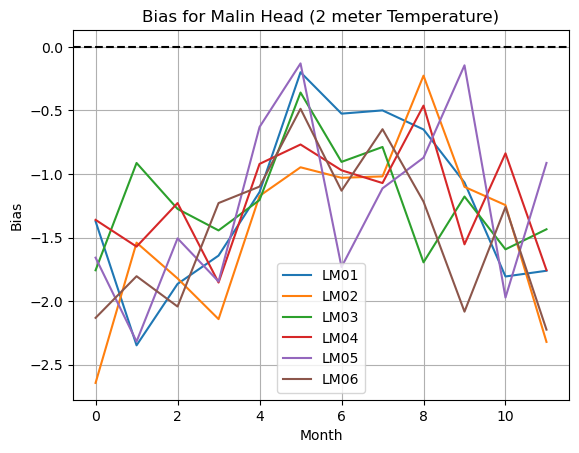

Stored 'bias_MAL' (ndarray)


In [7]:
bias_MAL = np.zeros([6,12])

for LM in range(6):
    for month in range(12):
        bias_MAL[LM, month] = np.mean(DIFF_F_O[LM, month,:])

for LM in range(6):
    plt.plot(bias_MAL[LM,:])
               
plt.grid()
plt.axhline(y=0.0, color='black', linestyle='--')
plt.legend(DIFF_F_O.coords['leadtime'].values)
plt.title("Bias for Malin Head (2 meter Temperature)")
plt.xlabel("Month")
plt.ylabel("Bias")
plt.show()

%store bias_MAL

The RMSE is given by the formula $$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^{N}(f_i-o_i)^2}$$

This average RMSE is calculated for each month month for each lead time and is plotted below.

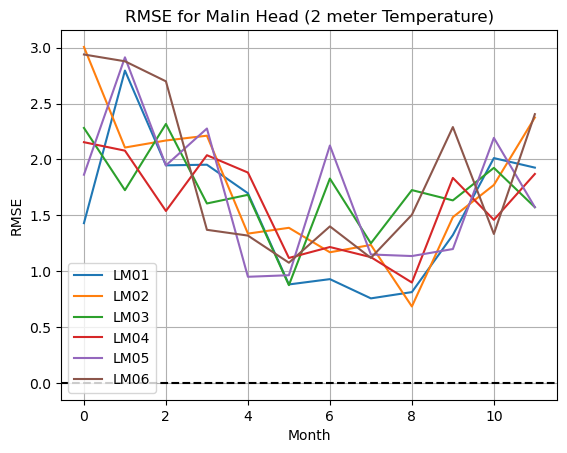

Stored 'RMSE_MAL' (ndarray)


In [8]:
RMSE_MAL = np.zeros([6,12])

for LM in range(6):
    for month in range(12):
        RMSE_MAL[LM, month] = np.sqrt(np.mean(DIFF_F_O[LM, month,:]**2))
        
for LM in range(6):
    plt.plot(RMSE_MAL[LM,:])
               
plt.grid()
plt.axhline(y=0.0, color='black', linestyle='--')
plt.legend(DIFF_F_O.coords['leadtime'].values)
plt.title("RMSE for Malin Head (2 meter Temperature)")
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.show()

%store RMSE_MAL

Create a new xarray, ``DIFF_F_C``, which is has dimensions "leadtime", "year" and month". Each element of this xarray is the climatological data subtracted off of its corresponding forecasted data.

In [9]:
DIFF_F_C = xr.DataArray(data=None, dims=['leadtime','month', 'year'], coords={'leadtime':
                                                                             ['LM01','LM02','LM03','LM04','LM05','LM06'],
                                                                             'year': range(2017,2023),
                                                                             'month': range(1,13)})

for LM in range(6):
    for month in range(12):
        DIFF_F_C[LM,month,:] = FC_data[LM].groupby('time.month')[month+1] - CLM_data[LM].groupby('time.month')[month+1]

Create a new xarray, ``DIFF_O_C``, which is has dimensions "leadtime", "year" and month". Each element of this xarray is the climatological data subtracted off of its corresponding observational data.

In [10]:
DIFF_O_C = xr.DataArray(data=None, dims=['leadtime','month', 'year'], coords={'leadtime':
                                                                             ['LM01','LM02','LM03','LM04','LM05','LM06'],
                                                                             'year': range(2017,2023),
                                                                             'month': range(1,13)})

for LM in range(6):
    for month in range(12):
        DIFF_O_C[LM,month,:] = OBS_data[LM].groupby('time.month')[month+1] - CLM_data[LM].groupby('time.month')[month+1]

The Anomaly Correlation Coefficient (ACC) is given by the formula $$ACC=\frac{\overline{(f_i-c_i)(o_i-c_i)}}{\sqrt{\overline{(f_i-c_i)^2}\cdot\overline{(o_i-c_i)^2}}}$$ where c_i is the climatological data at the ith time step.

This average RMSE is calculated for each month month for each lead time and is plotted below.

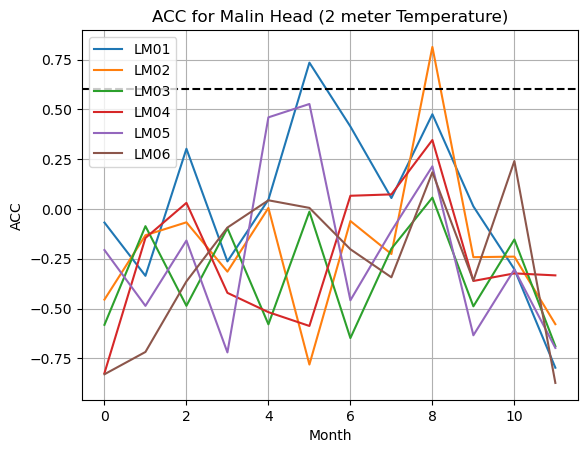

Stored 'ACC_MAL' (ndarray)


In [11]:
ACC_MAL = np.zeros([6,12])
ACC_num = np.zeros([6,12])
ACC_den = np.zeros([6,12])

for LM in range(6):
    for month in range(12):
        ACC_num[LM,month] = np.mean(DIFF_F_C[LM,month,:]*DIFF_O_C[LM,month,:])
        ACC_den[LM,month] = np.sqrt(np.mean(DIFF_F_C[LM,month,:]**2) * np.mean(DIFF_O_C[LM,month,:]**2))
        ACC_MAL[LM,month] = ACC_num[LM,month] / ACC_den[LM,month]

for LM in range(6):
    plt.plot(ACC_MAL[LM,:])
               
plt.grid()
plt.axhline(y=0.6, color='black', linestyle='--')
plt.legend(DIFF_F_C.coords['leadtime'].values)
plt.title("ACC for Malin Head (2 meter Temperature)")
plt.xlabel("Month")
plt.ylabel("ACC")
plt.show()

%store ACC_MAL

Read in the ensemble forecast data.

In [12]:
file_paths = ['C:/Users/durka/Downloads/Thesis_Data/type_fcmean_LM01.nc','C:/Users/durka/Downloads/Thesis_Data/type_fcmean_LM02.nc',
              'C:/Users/durka/Downloads/Thesis_Data/type_fcmean_LM03.nc','C:/Users/durka/Downloads/Thesis_Data/type_fcmean_LM04.nc',
              'C:/Users/durka/Downloads/Thesis_Data/type_fcmean_LM05.nc','C:/Users/durka/Downloads/Thesis_Data/type_fcmean_LM06.nc']

XRDAT = [xr.open_dataset(fp) for fp in file_paths]

Specify the latitude and longitude of Malin Head.

In [13]:
MALLAT = 55.372
MALLON = -7.339

Select the gridpoint nearest Malin Head using the ``.sel`` command.

In [14]:
MALFC = {0: XRDAT[0].sel(latitude=xr.DataArray([MALLAT], dims='lat'),
                         longitude=xr.DataArray([MALLON], dims='lon'),
                         method='nearest'),
         1: XRDAT[1].sel(latitude=xr.DataArray([MALLAT], dims='lat'),
                         longitude=xr.DataArray([MALLON], dims='lon'),
                         method='nearest'),
         2: XRDAT[2].sel(latitude=xr.DataArray([MALLAT], dims='lat'),
                         longitude=xr.DataArray([MALLON], dims='lon'),
                         method='nearest'),
         3: XRDAT[3].sel(latitude=xr.DataArray([MALLAT], dims='lat'),
                         longitude=xr.DataArray([MALLON], dims='lon'),
                         method='nearest'),
         4: XRDAT[4].sel(latitude=xr.DataArray([MALLAT], dims='lat'),
                         longitude=xr.DataArray([MALLON], dims='lon'),
                         method='nearest'),
         5: XRDAT[5].sel(latitude=xr.DataArray([MALLAT], dims='lat'),
                         longitude=xr.DataArray([MALLON], dims='lon'),
                         method='nearest')}

For calculation of the ROC, we need to read in the upper tercile of the climatology figures and for the Brier score we need both the upper and lower terciles.

In [15]:
%store -r CLM_t2m_lowertercile
%store -r CLM_t2m_uppertercile

Define a forecasted event as whenever the forecasted temperature is greater than or equal to the upper tercile of the climatological values for each ensemble member at each time step.

In [16]:
FC_events = xr.DataArray(data=None, dims=['leadtime','time', 'number'], coords={'leadtime': range(6),
                                                                                'time': date_range,
                                                                                'number': range(51)})

for LM in range(6):
    for t in range(60):
        for number in range(51):
            FC_events[LM,LM+t,number] = xr.where(MALFC[LM].t2m[t,number,0,0] - 273.15 >= CLM_t2m_uppertercile[4,LM+t], 1, 0)

Define an "event" as whenever the observed temperature is greater than or equal to the upper tercile of the climatalogical values at each time step

In [17]:
events = xr.DataArray(data=None, dims=['leadtime','time', 'number'], coords={'leadtime': range(6),
                                                                             'time': date_range,
                                                                             'number': range(51)})

for LM in range(6):
    for t in range(60):
        events[LM,LM+t,number] = xr.where(OBS_data[LM,LM+t] >= CLM_t2m_uppertercile[4,LM+t], 1, 0)


* ``tp`` records how often the event's probability is forecasted to be above the threshold and the event subsequently does occur.
* ``fn`` records how often the event's probability is forecasted to be below the threshold and the event subsequently does not occur.
* ``fp`` records how often the event's probability is forecasted to be below the threshold and the event subsequently does occur.
* ``tn`` records how often the event's probability is forecasted to be above the threshold and the event subsequently does not occur.

The ``hit_rate`` is given by the formula $$HR=\frac{tp}{tp+fn}$$
The ``false_alarm_rate`` is given by the formula $$FAR=\frac{fp}{fp+tn}$$

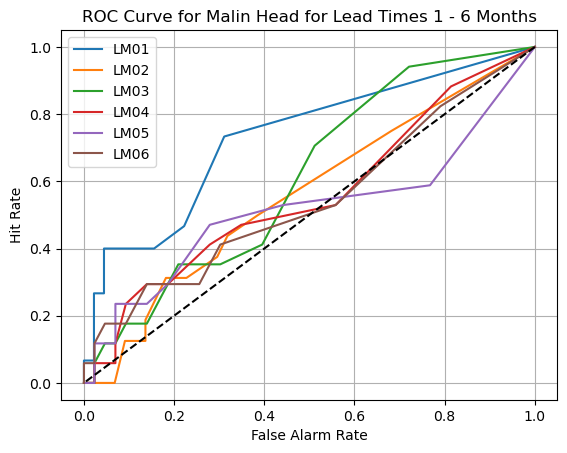

In [18]:
from scipy import integrate

ROC = np.zeros(6)
threshold = np.linspace(1, 0, 100)
hit_rate = np.zeros([6, np.size(threshold)])
false_alarm_rate = np.zeros([6, np.size(threshold)])

x = 0

for LM in range(6):
    for i in threshold:
        tp = np.count_nonzero((FC_events[LM,LM:60+LM].mean(dim='number') >= i) & (events[LM,LM:60+LM] == 1))
        fn = np.count_nonzero((FC_events[LM,LM:60+LM].mean(dim='number') < i) & (events[LM,LM:60+LM] == 1))
        hit_rate[LM,x] = tp/(tp+fn)
    
        fp = np.count_nonzero((FC_events[LM,LM:60+LM].mean(dim='number') >= i) & (events[LM,LM:60+LM] == 0))
        tn = np.count_nonzero((FC_events[LM,LM:60+LM].mean(dim='number') < i) & (events[LM,LM:60+LM] == 0))
        false_alarm_rate[LM,x] = fp/(fp+tn)
    
        x += 1
    
    x = 0
    
    plt.plot(false_alarm_rate[LM], hit_rate[LM])
    ROC[LM] = integrate.trapz(hit_rate[LM], false_alarm_rate[LM])

plt.plot(threshold, threshold, color='black', linestyle='--')
plt.legend(['LM01','LM02','LM03','LM04','LM05','LM06'])
plt.title("ROC Curve for Malin Head for Lead Times 1 - 6 Months")
plt.xlabel("False Alarm Rate")
plt.ylabel("Hit Rate")
plt.grid()

In [19]:
MAL_FAR=false_alarm_rate
MAL_HR=hit_rate
%store MAL_FAR
%store MAL_HR

Stored 'MAL_FAR' (ndarray)
Stored 'MAL_HR' (ndarray)


Create a 6x60x51 array, ``DIFF_FC``, representing 6 lead times, 60 time steps and 51 ensemble members.

At each time step for each ensemble member, check if the ensemble member's prediction is in the upper tercile of climatological values. If it is, set the corresponding entry of ``DIFF_FC`` equal to 1. If not, set it equal to 0. Repeat for all 6 lead times.

``FC_prob`` is a 6x60 array, where at each timestep, the average of all ensemble binary predictions is calculated and set as the corresponding value of ``FC_prob``. This average represents the proportion of ensemble members that predict the temperature will be in the upper tercile.

Also create a 6x60 array, ``DIFF_OBS``, where the value at each time step is set to 1 if the observed temperature was in the upper tercile, and 0 if not.

The Brier score is then given by the formula $$BS=\frac{1}{N}\sum_{i=1}^{N}(p_i-o_i)^2$$ where N is the number of time steps (60 months), $p_i$ is the forecast probability and $o_i$ is either 0 or 1.

6 Brier scores are calculated, one for each lead time.

In [20]:
DIFF_FC = np.zeros([6,60,51])

for LM in range(6):
    for i in range(60):
        for j in range(51):
            if np.array(MALFC[LM].t2m[i,j,0,0] - 273.15) > CLM_t2m_uppertercile[4,i+LM]:
                DIFF_FC[LM,i,j] = 1
            else:
                DIFF_FC[LM,i,j] = 0
            
FC_prob = np.zeros([6,60])
for LM in range(6):
    for i in range(60):
        FC_prob[LM,i] = DIFF_FC[LM,i,:].mean()
    
DIFF_OBS = np.zeros([6,60])
for LM in range(6):
    for i in range(60):
        if MALOBS[i+LM] > CLM_t2m_uppertercile[4,i+LM]:
            DIFF_OBS[LM,i] = 1
        else:
            DIFF_OBS[LM,i] = 0
    
Brier_Upper_MAL = np.zeros(6)
for LM in range(6):
    Brier_Upper_MAL[LM] = np.mean((DIFF_OBS[LM,:] - FC_prob[LM,:])**2)
    
Brier_Upper_MAL
%store Brier_Upper_MAL

Stored 'Brier_Upper_MAL' (ndarray)


Calculate the Brier score again, but this time checking if the forecasted and observed temperatures are in the lower tercile or not.

In [21]:
DIFF_FC = np.zeros([6,60,51])

for LM in range(6):
    for i in range(60):
        for j in range(51):
            if np.array(MALFC[LM].t2m[i,j,0,0] - 273.15) < CLM_t2m_lowertercile[4,i+LM]:
                DIFF_FC[LM,i,j] = 1
            else:
                DIFF_FC[LM,i,j] = 0
            
FC_prob = np.zeros([6,60])
for LM in range(6):
    for i in range(60):
        FC_prob[LM,i] = DIFF_FC[LM,i,:].mean()
    
DIFF_OBS = np.zeros([6,60])
for LM in range(6):
    for i in range(60):
        if MALOBS[i+LM] < CLM_t2m_lowertercile[4,i+LM]:
            DIFF_OBS[LM,i] = 1
        else:
            DIFF_OBS[LM,i] = 0
    
Brier_Lower_MAL = np.zeros(6)
for LM in range(6):
    Brier_Lower_MAL[LM] = np.mean((DIFF_OBS[LM,:] - FC_prob[LM,:])**2)
    
Brier_Lower_MAL
%store Brier_Lower_MAL

Stored 'Brier_Lower_MAL' (ndarray)


Finally, one more time but for the middle tercile.

In [22]:
DIFF_FC = np.zeros([6,60,51])

for LM in range(6):
    for i in range(60):
        for j in range(51):
            if np.array(MALFC[LM].t2m[i,j,0,0] - 273.15) < CLM_t2m_lowertercile[4,i+LM]:
                DIFF_FC[LM,i,j] = 0
            elif np.array(MALFC[LM].t2m[i,j,0,0] - 273.15) > CLM_t2m_uppertercile[4,i+LM]:
                DIFF_FC[LM,i,j] = 0
            else:
                DIFF_FC[LM,i,j] = 1
            
FC_prob = np.zeros([6,60])
for LM in range(6):
    for i in range(60):
        FC_prob[LM,i] = DIFF_FC[LM,i,:].mean()
    
DIFF_OBS = np.zeros([6,60])
for LM in range(6):
    for i in range(60):
        if MALOBS[i+LM] < CLM_t2m_lowertercile[4,i+LM]:
            DIFF_OBS[LM,i] = 0
        elif MALOBS[i+LM] > CLM_t2m_uppertercile[4,i+LM]:
            DIFF_OBS[LM,i] = 0
        else:
            DIFF_OBS[LM,i] = 1
    
Brier_Middle_MAL = np.zeros(6)
for LM in range(6):
    Brier_Middle_MAL[LM] = np.mean((DIFF_OBS[LM,:] - FC_prob[LM,:])**2)
    
Brier_Middle_MAL
%store Brier_Middle_MAL

Stored 'Brier_Middle_MAL' (ndarray)


Plot all three Brier scores, with increasing lead time on the x-axis.

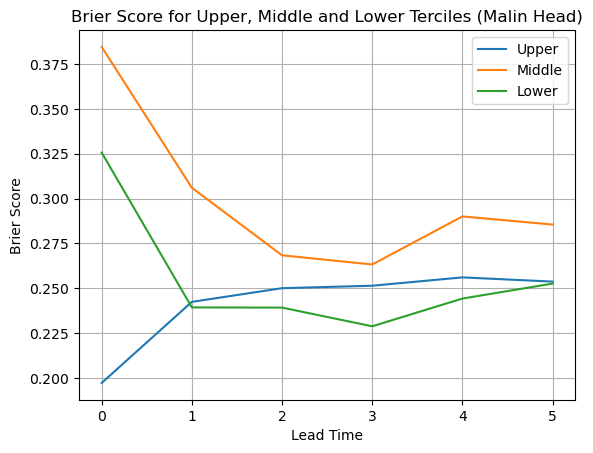

In [24]:
plt.plot(Brier_Upper_MAL, label='Upper')
plt.plot(Brier_Middle_MAL, label='Middle')
plt.plot(Brier_Lower_MAL, label='Lower')
plt.grid()
plt.legend()
plt.xlabel('Lead Time')
plt.ylabel('Brier Score')
plt.title('Brier Score for Upper, Middle and Lower Terciles (Malin Head)')
plt.show()